In [1]:
from time import time
import numpy as np
from matplotlib import pyplot as plt

# Qiskit
from qiskit import IBMQ

# Local modules
from utilities import startup, check_provider
from graphstate import GraphState, calc_negativities, plot_negativities_multi, calc_n_mean, plot_cxerr_corr

provider = startup()

Account enabled
Provider: ibm-q-melbourne


In [ ]:
check_provider()

In [2]:
import networkx as nx

def get_negativity_info(n_list, nmit_list):
    
    n_mean_dict, _ = calc_n_mean(n_list)
    n_mean = np.mean(list(n_mean_dict.values()))
    std = np.std(list(n_mean_dict.values()))

    nmit_mean_dict, _ = calc_n_mean(nmit_list)
    nmit_mean = np.mean(list(nmit_mean_dict.values()))
    std_mit = np.std(list(nmit_mean_dict.values()))
    
    n5 = get_largest_connected(n_mean_dict, threshold=0.025)
    n50 = get_largest_connected(n_mean_dict, threshold=0.25)
    n75 = get_largest_connected(n_mean_dict, threshold=0.75*0.5)
    n90 = get_largest_connected(n_mean_dict, threshold=0.9*0.5)
    
    nmit5 = get_largest_connected(nmit_mean_dict, threshold=0.025)
    nmit50 = get_largest_connected(nmit_mean_dict, threshold=0.25)
    nmit75 = get_largest_connected(nmit_mean_dict, threshold=0.75*0.5)
    nmit90 = get_largest_connected(nmit_mean_dict, threshold=0.9*0.5)
    
    info_dict = {'Mean negativity': n_mean,
                 'std': std,
                'Mean negativity (mit)': nmit_mean,
                 'std (mit)': std_mit,
                'Connected N>5%': len(n5),
                'Connected N>50%': len(n50),
                'Connected N>75%': len(n75),
                'Connected N>90%': len(n90),
                'Connected N>5% (mit)': len(nmit5),
                'Connected N>50% (mit)': len(nmit50),
                'Connected N>75% (mit)': len(nmit75),
                'Connected N>90% (mit)': len(nmit90)}

    return info_dict

def get_largest_connected(n_dict, threshold=0.25):
    
    edges = filter_edges(n_dict, threshold)
    G = nx.Graph()
    G.add_edges_from(edges)
    try:
        largest = max(nx.connected_components(G), key=len)
    except:
        largest = {}
    
    return largest
    
def filter_edges(n_dict, threshold=0.25/2):
    return [key for key, value in n_dict.items() if value >= threshold]

### Negativity Calculation and Plotting

In [3]:
plt.rc('font', size=12.5)

#### ibmq_lima

In [9]:
backend = provider.get_backend('ibmq_lima')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_lima (5 qubits)
Job 1 ID: 62e0854f3bc04172e4fd6c37
Job 2 ID: 62e085533bc0415ea8fd6c38


In [14]:
time0 = time()
backend = provider.get_backend('ibmq_lima')
job1 = backend.retrieve_job('62e0854f3bc04172e4fd6c37')
job2 = backend.retrieve_job('62e085533bc0415ea8fd6c38')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 4.20 s


{'Mean negativity': 0.36343288870551954,
 'std': 0.03614586182416435,
 'Mean negativity (mit)': 0.47020018641267863,
 'std (mit)': 0.011086446003699306,
 'Connected N>5%': 5,
 'Connected N>50%': 5,
 'Connected N>75%': 3,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 5,
 'Connected N>50% (mit)': 5,
 'Connected N>75% (mit)': 5,
 'Connected N>90% (mit)': 5}

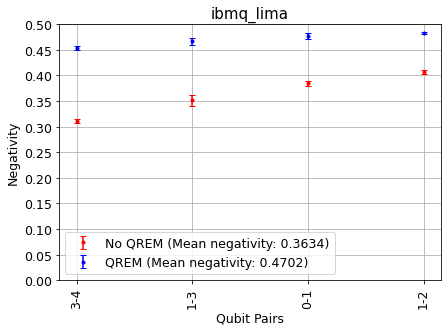

In [15]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibmq_belem

In [15]:
backend = provider.get_backend('ibmq_belem')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_belem (5 qubits)
Job 1 ID: 62debd33c2d082cf7108c178
Job 2 ID: 62debd371813981decc6cb22


In [16]:
time0 = time()
backend = provider.get_backend('ibmq_belem')
job1 = backend.retrieve_job('62debd33c2d082cf7108c178')
job2 = backend.retrieve_job('62debd371813981decc6cb22')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 4.38 s


{'Mean negativity': 0.3152408333586164,
 'std': 0.030163694348870854,
 'Mean negativity (mit)': 0.4270172426215747,
 'std (mit)': 0.009580048658452507,
 'Connected N>5%': 5,
 'Connected N>50%': 5,
 'Connected N>75%': 0,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 5,
 'Connected N>50% (mit)': 5,
 'Connected N>75% (mit)': 5,
 'Connected N>90% (mit)': 0}

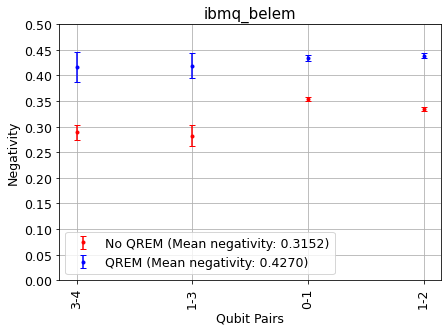

In [17]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibmq_quito

In [5]:
backend = provider.get_backend('ibmq_quito')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_quito (5 qubits)
Job 1 ID: 62e083cc22b5f5c9d5565888
Job 2 ID: 62e083d1c2d4972bd5e36bec


In [18]:
time0 = time()
backend = provider.get_backend('ibmq_quito')
job1 = backend.retrieve_job('62e083cc22b5f5c9d5565888')
job2 = backend.retrieve_job('62e083d1c2d4972bd5e36bec')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 3.65 s


{'Mean negativity': 0.3005996250992291,
 'std': 0.011843931894246254,
 'Mean negativity (mit)': 0.4855397455673087,
 'std (mit)': 0.009991937296500254,
 'Connected N>5%': 5,
 'Connected N>50%': 5,
 'Connected N>75%': 0,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 5,
 'Connected N>50% (mit)': 5,
 'Connected N>75% (mit)': 5,
 'Connected N>90% (mit)': 5}

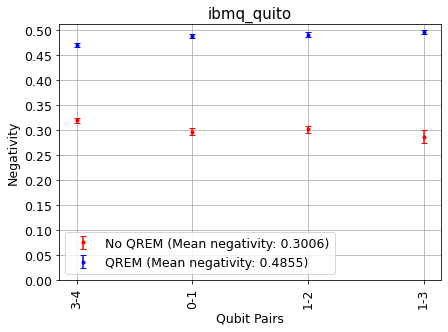

In [19]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibmq_manila

In [17]:
backend = provider.get_backend('ibmq_manila')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_manila (5 qubits)
Job 1 ID: 62debdad9ef0519cc8768fb4
Job 2 ID: 62debdb11813981a54c6cb2a


In [20]:
time0 = time()
backend = provider.get_backend('ibmq_manila')
job1 = backend.retrieve_job('62debdad9ef0519cc8768fb4')
job2 = backend.retrieve_job('62debdb11813981a54c6cb2a')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 4.93 s


{'Mean negativity': 0.38839167441458045,
 'std': 0.013378899171218215,
 'Mean negativity (mit)': 0.48689800222442786,
 'std (mit)': 0.0028244432643853143,
 'Connected N>5%': 5,
 'Connected N>50%': 5,
 'Connected N>75%': 5,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 5,
 'Connected N>50% (mit)': 5,
 'Connected N>75% (mit)': 5,
 'Connected N>90% (mit)': 5}

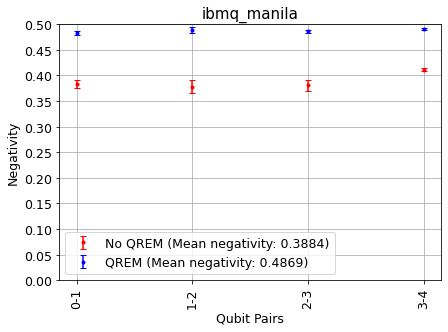

In [21]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibmq_jakarta

In [4]:
backend = provider.get_backend('ibmq_jakarta')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_jakarta (7 qubits)
Job 1 ID: 62e0bea3c2d497582ee36c59
Job 2 ID: 62e0beb28fc0975ff00a868f


In [ ]:
time0 = time()
backend = provider.get_backend('ibmq_jakarta')
job1 = backend.retrieve_job('62e0bea3c2d497582ee36c59')
job2 = backend.retrieve_job('62e0beb28fc0975ff00a868f')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 5.87 s


{'Mean negativity': 0.3028467270047333,
 'std': 0.028960399615682305,
 'Mean negativity (mit)': 0.48189924433819903,
 'std (mit)': 0.007166825807386201,
 'Connected N>5%': 7,
 'Connected N>50%': 7,
 'Connected N>75%': 0,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 7,
 'Connected N>50% (mit)': 7,
 'Connected N>75% (mit)': 7,
 'Connected N>90% (mit)': 7}

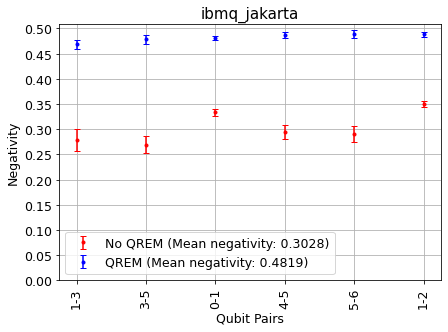

In [ ]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibm_oslo

In [10]:
backend = provider.get_backend('ibm_oslo')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_oslo (7 qubits)
Job 1 ID: 62e085925593a8ab36192710
Job 2 ID: 62e08599fb9fa11c75a31beb


In [24]:
time0 = time()
backend = provider.get_backend('ibm_oslo')
job1 = backend.retrieve_job('62e085925593a8ab36192710')
job2 = backend.retrieve_job('62e08599fb9fa11c75a31beb')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 6.01 s


{'Mean negativity': 0.402996108004936,
 'std': 0.018986107280654405,
 'Mean negativity (mit)': 0.4882854011274406,
 'std (mit)': 0.00985354920644814,
 'Connected N>5%': 7,
 'Connected N>50%': 7,
 'Connected N>75%': 6,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 7,
 'Connected N>50% (mit)': 7,
 'Connected N>75% (mit)': 7,
 'Connected N>90% (mit)': 7}

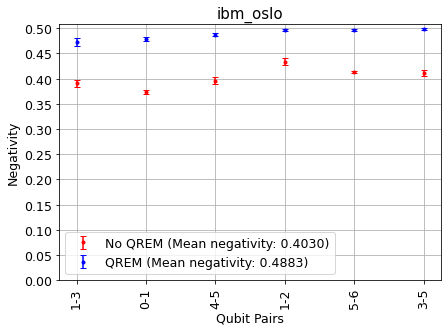

In [25]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibm_nairobi

In [58]:
backend = provider.get_backend('ibm_nairobi')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_nairobi (7 qubits)
Job 1 ID: 633859475706bc52c04659b4
Job 2 ID: 6338594f5706bca0ab4659b5


In [27]:
time0 = time()
backend = provider.get_backend('ibm_nairobi')
job1 = backend.retrieve_job('633859475706bc52c04659b4')
job2 = backend.retrieve_job('6338594f5706bca0ab4659b5')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 5.85 s


{'Mean negativity': 0.37498304553540945,
 'std': 0.005185117424300301,
 'Mean negativity (mit)': 0.48760564732337247,
 'std (mit)': 0.004256760509462615,
 'Connected N>5%': 7,
 'Connected N>50%': 7,
 'Connected N>75%': 3,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 7,
 'Connected N>50% (mit)': 7,
 'Connected N>75% (mit)': 7,
 'Connected N>90% (mit)': 7}

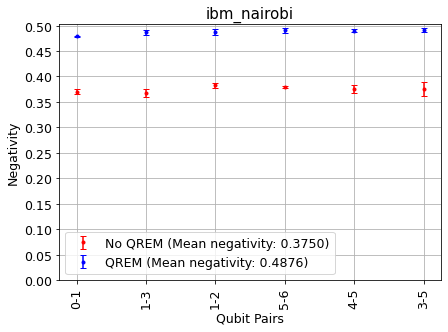

In [28]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibm_lagos

In [12]:
backend = provider.get_backend('ibm_lagos')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_lagos (7 qubits)
Job 1 ID: 62e085de3bc0414613fd6c39
Job 2 ID: 62e085e4c2d497f25fe36bee


In [29]:
time0 = time()
backend = provider.get_backend('ibm_lagos')
job1 = backend.retrieve_job('62e085de3bc0414613fd6c39')
job2 = backend.retrieve_job('62e085e4c2d497f25fe36bee')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 7.86 s


{'Mean negativity': 0.3716177905918778,
 'std': 0.025947508971476695,
 'Mean negativity (mit)': 0.4661721758610285,
 'std (mit)': 0.007606694957591938,
 'Connected N>5%': 7,
 'Connected N>50%': 7,
 'Connected N>75%': 3,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 7,
 'Connected N>50% (mit)': 7,
 'Connected N>75% (mit)': 7,
 'Connected N>90% (mit)': 7}

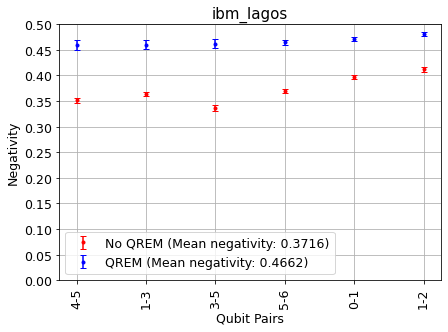

In [30]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibm_perth

In [13]:
backend = provider.get_backend('ibm_perth')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_perth (7 qubits)
Job 1 ID: 62e086025923b654835f3fbe
Job 2 ID: 62e086095923b634015f3fbf


In [31]:
time0 = time()
backend = provider.get_backend('ibm_perth')
job1 = backend.retrieve_job('62e086025923b654835f3fbe')
job2 = backend.retrieve_job('62e086095923b634015f3fbf')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 7.12 s


{'Mean negativity': 0.35278004758602916,
 'std': 0.014641472068305628,
 'Mean negativity (mit)': 0.48186634799616773,
 'std (mit)': 0.011011507581295953,
 'Connected N>5%': 7,
 'Connected N>50%': 7,
 'Connected N>75%': 0,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 7,
 'Connected N>50% (mit)': 7,
 'Connected N>75% (mit)': 7,
 'Connected N>90% (mit)': 7}

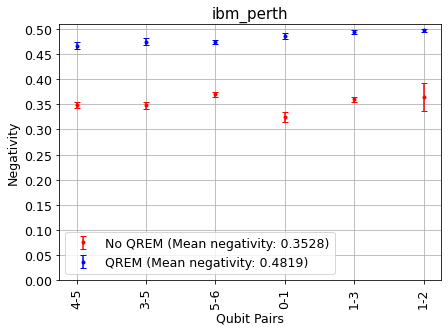

In [32]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibmq_guadalupe

In [14]:
backend = provider.get_backend('ibmq_guadalupe')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_guadalupe (16 qubits)
Job 1 ID: 62e762a215d03377cc49967b
Job 2 ID: 62e762b922b5f5d8cd568004


In [33]:
time0 = time()
backend = provider.get_backend('ibmq_guadalupe')
job1 = backend.retrieve_job('62e762a215d03377cc49967b')
job2 = backend.retrieve_job('62e762b922b5f5d8cd568004')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 61.68 s


{'Mean negativity': 0.3354010593037919,
 'std': 0.02692384053199414,
 'Mean negativity (mit)': 0.44691403712085065,
 'std (mit)': 0.03172860760674204,
 'Connected N>5%': 16,
 'Connected N>50%': 16,
 'Connected N>75%': 2,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 16,
 'Connected N>50% (mit)': 16,
 'Connected N>75% (mit)': 16,
 'Connected N>90% (mit)': 11}

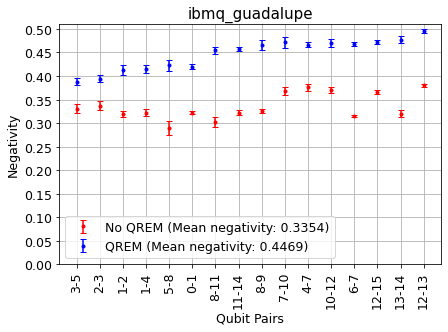

In [34]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibmq_toronto

In [18]:
backend = provider.get_backend('ibmq_toronto')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_toronto (27 qubits)
Job 1 ID: 62e007f6a4cdd20758511302
Job 2 ID: 62e008097b5403fa682dcd0a


In [35]:
time0 = time()
backend = provider.get_backend('ibmq_toronto')
job1 = backend.retrieve_job('62e007f6a4cdd20758511302')
job2 = backend.retrieve_job('62e008097b5403fa682dcd0a')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 105.47 s


{'Mean negativity': 0.22260218976939533,
 'std': 0.11771423130100589,
 'Mean negativity (mit)': 0.4034239943369352,
 'std (mit)': 0.07496613913150062,
 'Connected N>5%': 26,
 'Connected N>50%': 9,
 'Connected N>75%': 3,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 27,
 'Connected N>50% (mit)': 27,
 'Connected N>75% (mit)': 11,
 'Connected N>90% (mit)': 4}

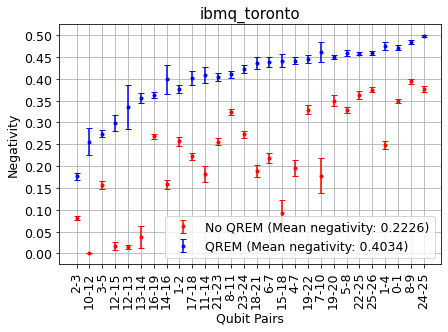

In [36]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibm_geneva

In [11]:
backend = provider.get_backend('ibm_geneva')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_geneva (27 qubits)
Job 1 ID: 62e1d476fb9fa11a0da32153
Job 2 ID: 62e1d48bc12764f4277eb995


In [37]:
time0 = time()
backend = provider.get_backend('ibm_geneva')
job1 = backend.retrieve_job('62e1d476fb9fa11a0da32153')
job2 = backend.retrieve_job('62e1d48bc12764f4277eb995')

graphstate = GraphState(backend)
#rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
#rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
#time1 = time()
#print(f'Time elapsed: {time1 - time0:.2f} s')

{'Mean negativity': 0.22260218976939533,
 'std': 0.11771423130100589,
 'Mean negativity (mit)': 0.4034239943369352,
 'std (mit)': 0.07496613913150062,
 'Connected N>5%': 26,
 'Connected N>50%': 9,
 'Connected N>75%': 3,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 27,
 'Connected N>50% (mit)': 27,
 'Connected N>75% (mit)': 11,
 'Connected N>90% (mit)': 4}

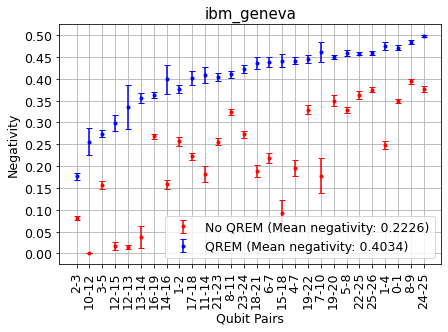

In [38]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibm_hanoi

In [13]:
backend = provider.get_backend('ibm_hanoi')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_hanoi (27 qubits)
Job 1 ID: 62debb30a7255f2ce80560da
Job 2 ID: 62debb76e52ec50930ce06a5


In [39]:
time0 = time()
backend = provider.get_backend('ibm_hanoi')
job1 = backend.retrieve_job('62debb30a7255f2ce80560da')
job2 = backend.retrieve_job('62debb76e52ec50930ce06a5')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 114.58 s


{'Mean negativity': 0.3299162483675386,
 'std': 0.06584429559717044,
 'Mean negativity (mit)': 0.46732187200937647,
 'std (mit)': 0.026076711098129188,
 'Connected N>5%': 27,
 'Connected N>50%': 26,
 'Connected N>75%': 3,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 27,
 'Connected N>50% (mit)': 27,
 'Connected N>75% (mit)': 27,
 'Connected N>90% (mit)': 17}

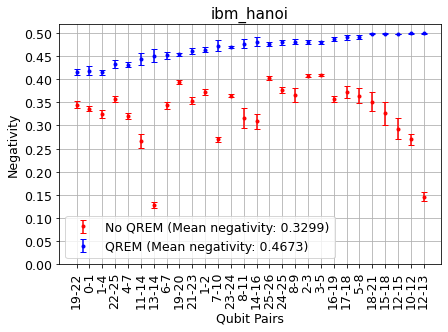

In [40]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibm_auckland

In [3]:
backend = provider.get_backend('ibm_auckland')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_auckland (27 qubits)
Job 1 ID: 62e0b39822b5f585165658b4
Job 2 ID: 62e0b3b2c2d497736fe36c1d


In [41]:
time0 = time()
backend = provider.get_backend('ibm_auckland')
job1 = backend.retrieve_job('62e0b39822b5f585165658b4')
job2 = backend.retrieve_job('62e0b3b2c2d497736fe36c1d')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 124.06 s


{'Mean negativity': 0.3724670214168043,
 'std': 0.06496949905202656,
 'Mean negativity (mit)': 0.4373778384081201,
 'std (mit)': 0.05971286131776886,
 'Connected N>5%': 27,
 'Connected N>50%': 26,
 'Connected N>75%': 13,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 27,
 'Connected N>50% (mit)': 27,
 'Connected N>75% (mit)': 26,
 'Connected N>90% (mit)': 13}

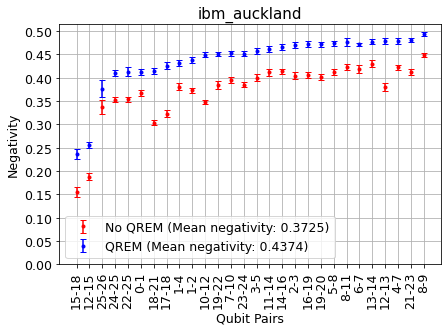

In [42]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibm_cairo

In [16]:
backend = provider.get_backend('ibm_cairo')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_cairo (27 qubits)
Job 1 ID: 62e006f6d5e93a5b6263784c
Job 2 ID: 62e007079ef051fa937697c1


In [43]:
time0 = time()
backend = provider.get_backend('ibm_cairo')
job1 = backend.retrieve_job('62e006f6d5e93a5b6263784c')
job2 = backend.retrieve_job('62e007079ef051fa937697c1')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 93.28 s


{'Mean negativity': 0.3558325725154137,
 'std': 0.03876550679521127,
 'Mean negativity (mit)': 0.45504250120077694,
 'std (mit)': 0.02603492973030284,
 'Connected N>5%': 27,
 'Connected N>50%': 27,
 'Connected N>75%': 4,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 27,
 'Connected N>50% (mit)': 27,
 'Connected N>75% (mit)': 27,
 'Connected N>90% (mit)': 9}

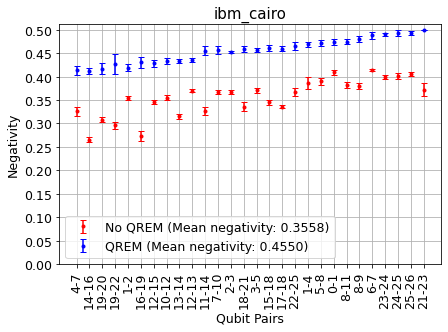

In [44]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibmq_mumbai

In [17]:
backend = provider.get_backend('ibmq_mumbai')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_mumbai (27 qubits)
Job 1 ID: 62e007759ef05199917697d7
Job 2 ID: 62e0078aa7255f3449056904


In [45]:
time0 = time()
backend = provider.get_backend('ibmq_mumbai')
job1 = backend.retrieve_job('62e007759ef05199917697d7')
job2 = backend.retrieve_job('62e0078aa7255f3449056904')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 109.67 s


{'Mean negativity': 0.31547185263394145,
 'std': 0.08832531161488551,
 'Mean negativity (mit)': 0.4596723719385011,
 'std (mit)': 0.07822693979787759,
 'Connected N>5%': 27,
 'Connected N>50%': 23,
 'Connected N>75%': 4,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 27,
 'Connected N>50% (mit)': 27,
 'Connected N>75% (mit)': 27,
 'Connected N>90% (mit)': 23}

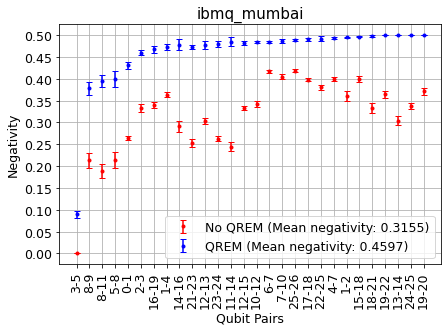

In [46]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibmq_montreal

In [ ]:
backend = provider.get_backend('ibmq_montreal')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_montreal (27 qubits)
Job 1 ID: 62e006677b5403911c2dccef
Job 2 ID: 62e0067d1813982307c6d2c3


In [47]:
time0 = time()
backend = provider.get_backend('ibmq_montreal')
job1 = backend.retrieve_job('62e006677b5403911c2dccef')
job2 = backend.retrieve_job('62e0067d1813982307c6d2c3')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 122.65 s


{'Mean negativity': 0.24721293722670737,
 'std': 0.061555723387827124,
 'Mean negativity (mit)': 0.4240553438431984,
 'std (mit)': 0.05454631863306708,
 'Connected N>5%': 27,
 'Connected N>50%': 8,
 'Connected N>75%': 0,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 27,
 'Connected N>50% (mit)': 27,
 'Connected N>75% (mit)': 24,
 'Connected N>90% (mit)': 8}

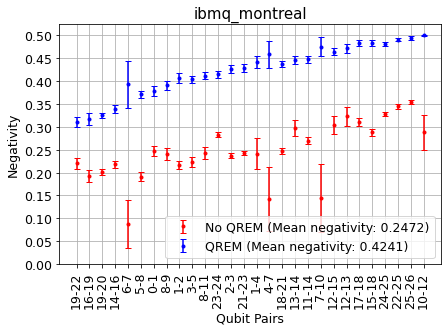

In [48]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

Qubit 7 had an anomously high readout error 3.265e-1 (mean 4.129e-2)

#### ibmq_kolkata

In [ ]:
backend = provider.get_backend('ibmq_kolkata')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

In [49]:
time0 = time()
backend = provider.get_backend('ibmq_kolkata')
job1 = backend.retrieve_job('62e0b33b5593a82bd1192732')
job2 = backend.retrieve_job('62e0b3558fc097738f0a8655')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 116.11 s


{'Mean negativity': 0.3332983963744673,
 'std': 0.11882553838988134,
 'Mean negativity (mit)': 0.40714102791650403,
 'std (mit)': 0.1344759561379048,
 'Connected N>5%': 27,
 'Connected N>50%': 24,
 'Connected N>75%': 9,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 27,
 'Connected N>50% (mit)': 25,
 'Connected N>75% (mit)': 22,
 'Connected N>90% (mit)': 11}

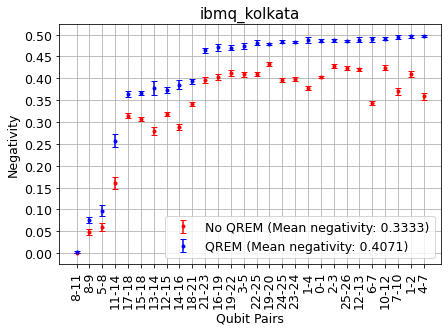

In [50]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibm_washington

In [3]:
backend = provider.get_backend('ibm_washington')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_washington (127 qubits)
Job 1 ID: 630bf9359877ca68932a4cc7
Job 2 ID: 630bf9d56d08101c02db5117


In [4]:
time0 = time()
backend = provider.get_backend('ibm_washington')
#job1 = backend.retrieve_job('630bf9359877ca68932a4cc7')
#job2 = backend.retrieve_job('630bf9d56d08101c02db5117')
#job1 = backend.retrieve_job('62f9b8033eae6d60a8d3b1ce')
#job2 = backend.retrieve_job('62f9b888d7bba196db87a916')
job1 = backend.retrieve_job('62e7633bac90f75e39c85ceb')
job2 = backend.retrieve_job('62e763a015d033aaad49968a')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 585.18 s


{'Mean negativity': 0.25561214245275754,
 'std': 0.1312353936810813,
 'Mean negativity (mit)': 0.3706253120877713,
 'std (mit)': 0.13748569904735206,
 'Connected N>5%': 113,
 'Connected N>50%': 82,
 'Connected N>75%': 10,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 123,
 'Connected N>50% (mit)': 109,
 'Connected N>75% (mit)': 92,
 'Connected N>90% (mit)': 32}

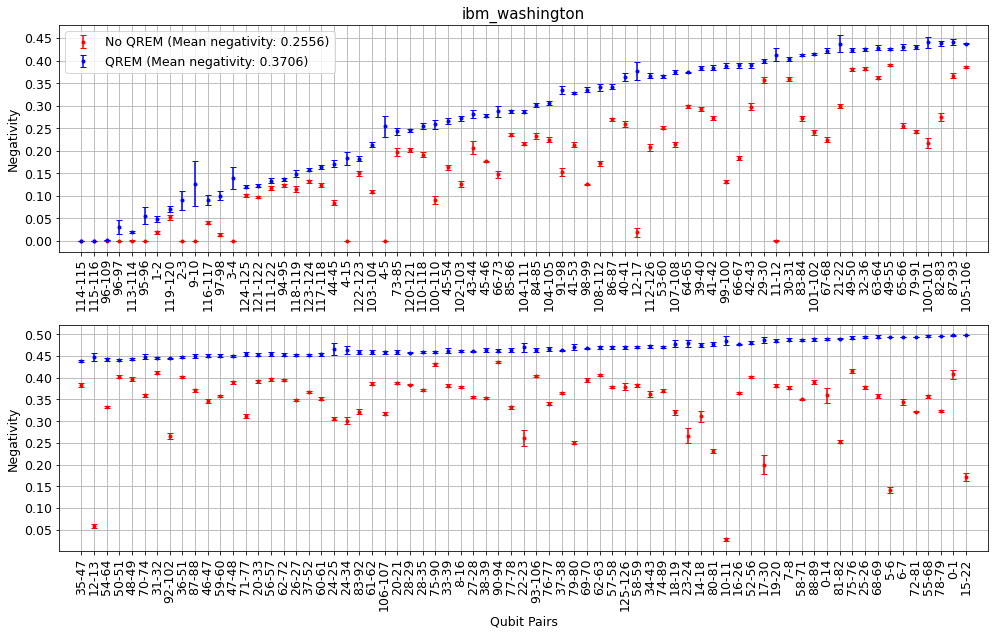

In [5]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

#fig = plot_negativities_multi(backend, n_list, nmit_list, figsize=(21, 7))
#fig.tight_layout()
#fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 9))

edges = n_list[0].keys()
n_mean, n_std = calc_n_mean(n_list)

# Convert into array for plotting
X = np.array([f'{edge[0]}-{edge[1]}' for edge in edges])
Y0 = np.fromiter(n_mean.values(), float)
Y0err = np.fromiter(n_std.values(), float)

# If mitigated results are included
nmit_mean, nmit_std = calc_n_mean(nmit_list)

Y1 = np.fromiter(nmit_mean.values(), float)
Y1err = np.fromiter(nmit_std.values(), float)
# Order in increasing minimum negativity (QREM)
Y1min = Y1 - Y1err
idx = Y1min.argsort()
Y1 = Y1[idx]
Y1err = Y1err[idx]

X = X[idx]
Y0 = Y0[idx]
Y0err = Y0err[idx]

hp = int(len(X)/2)

ax1.errorbar(X[:hp], Y0[:hp], yerr=Y0err[:hp], capsize=3, fmt='.', c='r', 
            label=f'No QREM (Mean negativity: {np.mean(Y0):.4f})')

ax1.errorbar(X[:hp], Y1[:hp], yerr=Y1err[:hp], capsize=3, fmt='.', c='b', 
            label=f'QREM (Mean negativity: {np.mean(Y1):.4f})')

ax2.errorbar(X[hp:], Y0[hp:], yerr=Y0err[hp:], capsize=3, fmt='.', c='r', 
            label=f'No QREM (Mean negativity: {np.mean(Y0):.4f})')

ax2.errorbar(X[hp:], Y1[hp:], yerr=Y1err[hp:], capsize=3, fmt='.', c='b', 
            label=f'QREM (Mean negativity: {np.mean(Y1):.4f})')

for ax in (ax1, ax2):
    ax.set_yticks(np.arange(0, 0.55, 0.05))
    ax.tick_params(axis='x', labelrotation=90)
    ax.grid()
    ax.set_ylabel("Negativity")
    ax.margins(0.025, 0.05)
    
ax1.legend()
ax2.set_xlabel("Qubit Pairs")
ax1.set_title(backend.name())
fig.set_tight_layout(True)

fig.savefig('output/negativities/ibm_washington_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### Negativity Map

In [6]:
import matplotlib as mpl
from qiskit.visualization import plot_gate_map, plot_coupling_map
from qubit_coords import qubit_coords127

plt.rc('font', size=13)

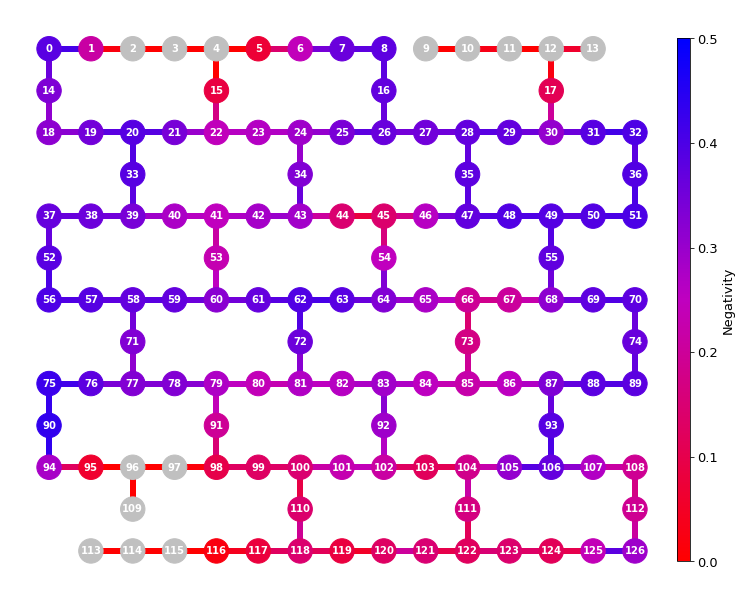

In [7]:
nqubits = 127
#n_dict = nmit_mean
n_dict = n_mean

cmap = mpl.cm.get_cmap('RdBu')
cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",['r', 'm', 'b'])
#cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",['tab:red', 'tab:purple', 'tab:blue'])

edges = filter_edges(n_dict, threshold=0.025)
G = nx.Graph()
G.add_edges_from(edges)
unconnected = list(set(range(127)) - list(nx.connected_components(G))[0])

qubit_n = np.zeros(nqubits)
qubit_color = []
edge_list = []
line_color = []

for key, values in n_dict.items():
    edge_list.append(key)
    line_color.append(mpl.colors.to_hex(cmap(2*values), keep_alpha=True))
    qubit_n[key[0]] += values
    qubit_n[key[1]] += values
    
for i, n in enumerate(qubit_n):
    x = 2*n/graphstate.graph.degree[i]
    if i in unconnected:
        #qubit_color.append('#D3D3D3')
        qubit_color.append('#C0C0C0')
    else:
        qubit_color.append(mpl.colors.to_hex(cmap(x), keep_alpha=True))

fig = plot_coupling_map(nqubits, qubit_coords127, edge_list, line_color=line_color, qubit_color=qubit_color,
                        line_width=6, figsize=(12,12))

norm = mpl.colors.Normalize(vmin=0, vmax=0.5)

ax = fig.get_axes()[0]
cax = fig.add_axes([0.9, 0.2, 0.015, 0.605])

im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(im, cax=cax, orientation='vertical', label='Negativity')
fig.savefig('output/ghznmap127.png', dpi=400)

fig

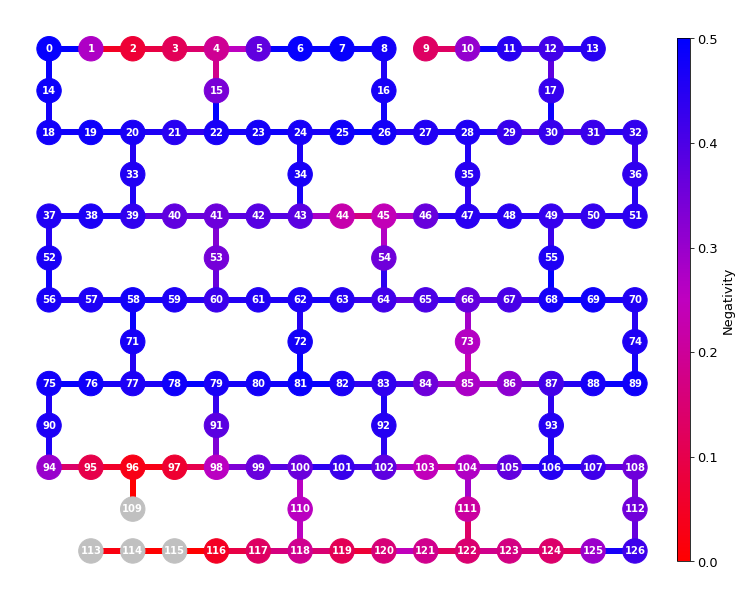

In [8]:
nqubits = 127
n_dict = nmit_mean
#n_dict = n_mean

cmap = mpl.cm.get_cmap('RdBu')
cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",['r', 'm', 'b'])
#cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",['tab:red', 'tab:purple', 'tab:blue'])

edges = filter_edges(n_dict, threshold=0.025)
G = nx.Graph()
G.add_edges_from(edges)
unconnected = list(set(range(127)) - list(nx.connected_components(G))[0])

qubit_n = np.zeros(nqubits)
qubit_color = []
edge_list = []
line_color = []

for key, values in n_dict.items():
    edge_list.append(key)
    line_color.append(mpl.colors.to_hex(cmap(2*values), keep_alpha=True))
    qubit_n[key[0]] += values
    qubit_n[key[1]] += values
    
for i, n in enumerate(qubit_n):
    x = 2*n/graphstate.graph.degree[i]
    if i in unconnected:
        #qubit_color.append('#D3D3D3')
        qubit_color.append('#C0C0C0')
    else:
        qubit_color.append(mpl.colors.to_hex(cmap(x), keep_alpha=True))

fig = plot_coupling_map(nqubits, qubit_coords127, edge_list, line_color=line_color, qubit_color=qubit_color,
                        line_width=6, figsize=(12,12))

norm = mpl.colors.Normalize(vmin=0, vmax=0.5)

ax = fig.get_axes()[0]
cax = fig.add_axes([0.9, 0.2, 0.015, 0.605])

im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(im, cax=cax, orientation='vertical', label='Negativity')
fig.savefig('output/ghznmitmap127.png', dpi=400)

fig

## Negativity Correlations

In [9]:
from numpy.polynomial.polynomial import polyfit
from scipy.stats import pearsonr


n_mean = calc_n_mean(n_list)
nmit_mean = calc_n_mean(nmit_list)
properties = job1.properties()
adj_edges = graphstate.adj_edges

n_meanf = {}
nmit_meanf = {}
edges = n_mean[0].keys()
for edge in edges:
    err = properties.gate_error('cx', edge)
    if err < 0.1:
        n_meanf[edge] = n_mean[0][edge]
        nmit_meanf[edge] = nmit_mean[0][edge]

#fig1a = plot_cxerr_corr(properties, adj_edges, n_meanf, inc_adj=False)
X, Y0 = plot_cxerr_corr(properties, adj_edges, n_meanf, inc_adj=False)
#fig2a = plot_cxerr_corr(properties, adj_edges, nmit_meanf, inc_adj=False)
X, Y1 = plot_cxerr_corr(properties, adj_edges, nmit_meanf, inc_adj=False)

c0, m0 = polyfit(X, Y0, 1)
c1, m1 = polyfit(X, Y1, 1)
Xfit = np.linspace(min(X), max(X), 100)

corr0, _ = pearsonr(X, Y0)
corr1, _ = pearsonr(X, Y1)

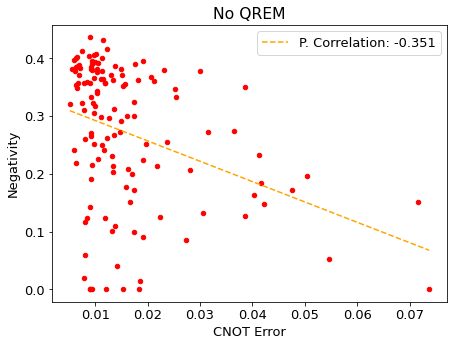

In [10]:
plt.rc('font', size=13)
fig, ax = plt.subplots(figsize=(6.5, 5))
ax.scatter(X, Y0, color='red', s=20)
ax.plot(Xfit, m0*Xfit+c0, ls='--', color='orange', label=f'P. Correlation: {corr0:.3f}')

ax.set_title('No QREM')

ax.set_ylabel('Negativity')
ax.set_xlabel('CNOT Error')

ax.legend(loc=1)

fig.set_tight_layout(True)
fig.savefig('output/negativitycorrelation1', dpi=300)

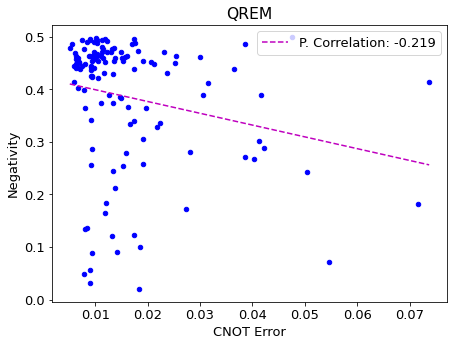

In [11]:
plt.rc('font', size=13)
fig, ax = plt.subplots(figsize=(6.5, 5))
ax.scatter(X, Y1, color='b', s=20)
ax.plot(Xfit, m1*Xfit+c1, ls='--', color='m', label=f'P. Correlation: {corr1:.3f}')

ax.set_title('QREM')

ax.set_ylabel('Negativity')
ax.set_xlabel('CNOT Error')

ax.legend(loc=1)

fig.set_tight_layout(True)
fig.savefig('output/negativitycorrelation2', dpi=300)

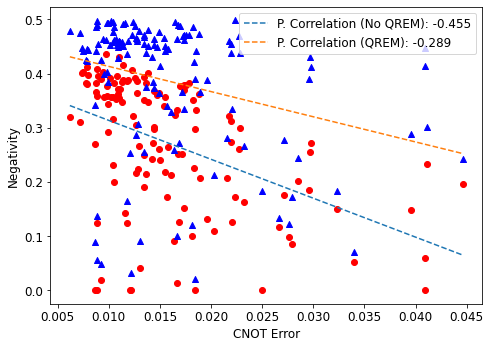

In [93]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(X, Y0, marker='o', color='r')
ax.plot(Xfit, m0*Xfit+c0, ls='--', label=f'P. Correlation (No QREM): {corr0:.3f}')
ax.scatter(X, Y1, marker='^', color='b')
ax.plot(Xfit, m1*Xfit+c1, ls='--', label=f'P. Correlation (QREM): {corr1:.3f}')

ax.set_ylabel('Negativity')
ax.set_xlabel('CNOT Error')

ax.legend()
#ax.legend(loc=1)

fig.set_tight_layout(True)
#fig.savefig('output/negativitycorrelation', dpi=300)